# Background

We derive expressions for the survival probability, denoted as $S(u | \theta)$, that two loci separated by $u$ units share the same most recent common ancestor for a pair of individuals, given a demographic model with parameters $\theta$.

## Under SMC

In [1]:
from sympy import *
init_printing()

Ne1 = Symbol('N_1', nonzero=True, positive=True) # Contemporary diploid population size at epoch i
Ne2 = Symbol('N_2', nonzero=True, positive=True) # Contemporary diploid population size at epoch i+1
Ne3 = Symbol('N_3', nonzero=True, positive=True) # Contemporary diploid population size at epoch i+1
t = Symbol('t', nonzero=True, positive=True) # Time
t1 = Symbol('ti', nonzero=True, positive=True) # Time ti
t2 = Symbol('tj', nonzero=True, positive=True) # Time ti
u = Symbol('u', positive=True) # Distance (Morgan)
x = Symbol('x', positive=True) # Placeholder


In [2]:
# Special case 1
gamma1 = 1 / (2*Ne1) # Coalescent rate
Gamma1 = 0 + integrate(gamma1,(x, 0, t)) # Cumulative coalescent rate
tmrca1 = gamma1 * exp(-Gamma1)
# Any intermediate epoch is of the form
gamma2 = 1 / (2*Ne2)
Gamma2 = Gamma1.subs({t: t1}) + integrate(gamma2,(x, t1, t))
tmrca2 = gamma2 * exp(-Gamma2)
# Last epoch 
gamma3 = 1 / (2*Ne3)
Gamma3 = Gamma2.subs({t: t2}) + integrate(gamma3,(x, t2, t))
tmrca3 = gamma3 * exp(-Gamma3)

In [3]:
piece1 = simplify(exp(-2*t*u) * tmrca1)
piece2 = simplify(exp(-2*t*u) * tmrca2)
piece3 = simplify(exp(-2*t*u) * tmrca3)
piece1, piece2, piece3

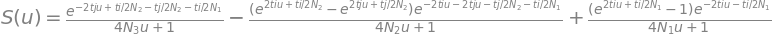

In [4]:
survival = integrate(piece1, (t, 0, t1)).simplify() + \
    integrate(piece2, (t, t1, t2)).simplify() + \
    integrate(piece3, (t, t2, oo)).simplify()
Eq(symbols('S(u)'), simplify(survival))

## Generalization

In [120]:
from sympy import *
import numpy as np
init_printing()

# Helper function to re-scale Legendre Gaussian quadrature rules
def gauss(a, b, n=10):
    x, w = np.polynomial.legendre.leggauss(n)
    w = (b - a) / 2 * w
    x = (b - a) / 2 * x + (a + b) / 2
    return x, w

def create_multi_epoch_model(epochs, a_vals, b_vals):
    # Symbols
    t = Symbol('t', nonzero=True, positive=True)
    x = Symbol('x', positive=True)
    u = Symbol('u', positive=True)
    
    # Build Ne and time symbols
    Ne_symbols, time_symbols = [], []
    for time_bound, Ne_name in epochs:
        Ne_symbols.append(Symbol(Ne_name, nonzero=True, positive=True))
        if time_bound is not None:
            if isinstance(time_bound, str):
                time_symbols.append(Symbol(time_bound, nonzero=True, positive=True))
            else:
                time_symbols.append(time_bound)
        else:
            time_symbols.append(None)
    
    # Build cumulative rate and survival terms
    pieces = []
    Gamma_prev, t_prev = 0, 0
    
    for i, Ne in enumerate(Ne_symbols):
        gamma = 1 / (2 * Ne)
        t_curr = time_symbols[i]
        
        if i == 0:
            Gamma = Gamma_prev + integrate(gamma, (x, 0, t))
        else:
            Gamma = Gamma_prev + integrate(gamma, (x, t_prev, t))
        
        tmrca = gamma * exp(-Gamma)
        piece = exp(-2*t*u) * tmrca
        pieces.append(simplify(piece))
        
        if t_curr is not None:
            Gamma_prev = Gamma.subs({t: t_curr})
            t_prev = t_curr
            break # Sanity check
    
    survival_terms, t_lower = [], 0
    for i in range(len(epochs)):
        t_upper = time_symbols[i]
        if t_upper is None:
            term = integrate(pieces[i], (t, t_lower, oo))
        else:
            term = integrate(pieces[i], (t, t_lower, t_upper))
        survival_terms.append(simplify(term))
        t_lower = t_upper
    
    expr = simplify(sum(survival_terms))
    
    # Compute symbolic results for each (a, b) pair
    results = []
    for a, b in zip(a_vals, b_vals):
        xs, ws = gauss(a, b, n=10)
        val = sum(expr.subs(u, x_val).simplify() / (b-a) * w for x_val, w in zip(xs, ws))
        results.append(val)
    
    # Return as a SymPy column vector
    return Matrix(results)


In [126]:
epochs_3 = [
    ('t_1', 'N_1'),   # Epoch 1: [0, t_i] with Ne = N_1
    ('t_2', 'N_2'),   # Epoch 2: [t_i, t_j] with Ne = N_2
    ('t_3', 'N_3'),   # Epoch 2: [t_i, t_j] with Ne = N_3
    (None, 'N_4')     # Epoch 3: [t_j, ∞] with Ne = N_4
]

create_multi_epoch_model(epochs_3, [1e-3, 2e-3], [2e-3, 3e-3])

⎡                                               t₂     t₃     t₁     t₂     t₁ ↪
⎢                    -0.00397390652851717⋅t₃ + ──── - ──── + ──── - ──── - ─── ↪
⎢                                              2⋅N₃   2⋅N₃   2⋅N₂   2⋅N₂   2⋅N ↪
⎢0.0333356721543436⋅ℯ                                                          ↪
⎢───────────────────────────────────────────────────────────────────────────── ↪
⎢                          0.00794781305703434⋅N₄ + 1                          ↪
⎢                                                                              ↪
⎢                                                      t₂     t₃     t₁     t₂ ↪
⎢                           -0.00597390652851717⋅t₃ + ──── - ──── + ──── - ─── ↪
⎢                                                     2⋅N₃   2⋅N₃   2⋅N₂   2⋅N ↪
⎢       0.0333356721543436⋅ℯ                                                   ↪
⎢       ────────────────────────────────────────────────────────────────────── ↪
⎣                           

In [124]:

from sympytensor import SympyDeterministic
with pm.Model() as model:
    # Priors
    N_1 = pm.Uniform("N_1", 0, 2000)
    N_2 = pm.Uniform("N_2", 0, 2000)
    N_3 = pm.Uniform("N_3",0, 2000)
    t_1 = pm.Uniform("t_1", 0, 100)
    t_2 = pm.Uniform("t_2", 0, 100)
    # Deterministic function from sympy → numpy
    survival_prob = SympyDeterministic('survival_prob', create_multi_epoch_model(epochs_3, [1e-3, 2e-3], [2e-3, 3e-3]))
    trace = pm.sample()

 Progress                   Draws   Divergences   Step size   Grad evals   Sampling Speed    Elapsed   Remaining  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━━━━━━━━━━━━━━━━━   2000    0             0.84        3            6167.32 draws/s   0:00:00   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━   2000    0             0.78        7            5854.06 draws/s   0:00:00   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━   2000    0             0.79        3            5182.74 draws/s   0:00:00   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━   2000    0             0.83        3            4198.40 draws/s   0:00:00   0:00:00

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


array([[<Axes: title={'center': 'survival_prob'}>,
        <Axes: title={'center': 'survival_prob'}>]], dtype=object)

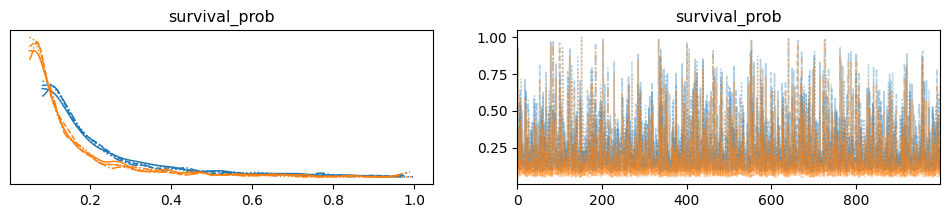

In [123]:
import arviz as az
az.plot_trace(trace, var_names=['survival_prob'])